In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import sys
import numpy as np

from multifield_combined import MultifieldDataset

import torch
from torch import nn
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      # May train faster but cost more memory

CUDA Available


In [3]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, FMAPS, FMAPS_NORM, FPARAMS,
                              splits, batch_size, *, memmap=True,
                              shuffle=True, seed=None, verbose=False):

    # whether rotations and flippings are kept in memory
    data_set = MultifieldDataset(
        mode, FMAPS, FMAPS_NORM, FPARAMS, splits,
        norm_params=True, memmap=memmap, seed=seed, verbose=True
    )
    data_loader = DataLoader(
        dataset=data_set, batch_size=batch_size, shuffle=shuffle
    )
    return data_loader

In [4]:
class model_so3(nn.Module):
    def __init__(self,
                 n_channels, n_filters,
                 kernel_size, padding, padding_mode, stride,
                 dropout_rate=0.2):
        super(model_so3, self).__init__()

        # Possible activation functions
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        # Input parameter dependent modules
        self.dropout   = nn.Dropout(p=dropout_rate)
        
        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(n_channels, 2*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.C02 = nn.Conv2d(2*n_filters, 2*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.C03 = nn.Conv2d(2*n_filters, 2*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B01 = nn.BatchNorm2d(2*n_filters)
        self.B02 = nn.BatchNorm2d(2*n_filters)
        self.B03 = nn.BatchNorm2d(2*n_filters)
        
        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*n_filters, 4*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.C12 = nn.Conv2d(4*n_filters, 4*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.C13 = nn.Conv2d(4*n_filters, 4*n_filters,
                             kernel_size=2,
                             stride=2,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B11 = nn.BatchNorm2d(4*n_filters)
        self.B12 = nn.BatchNorm2d(4*n_filters)
        self.B13 = nn.BatchNorm2d(4*n_filters)
        
        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*n_filters, 8*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B21 = nn.BatchNorm2d(8*n_filters)
        self.C22 = nn.Conv2d(8*n_filters, 8*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B22 = nn.BatchNorm2d(8*n_filters)
        self.C23 = nn.Conv2d(8*n_filters, 8*n_filters,
                             kernel_size=2,
                             stride=2,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B23 = nn.BatchNorm2d(8*n_filters)
        
        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*n_filters, 16*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B31 = nn.BatchNorm2d(16*n_filters)
        self.C32 = nn.Conv2d(16*n_filters, 16*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B32 = nn.BatchNorm2d(16*n_filters)
        self.C33 = nn.Conv2d(16*n_filters, 16*n_filters,
                             kernel_size=2,
                             stride=2,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B33 = nn.BatchNorm2d(16*n_filters)
        
        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*n_filters, 32*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B41 = nn.BatchNorm2d(32*n_filters)
        self.C42 = nn.Conv2d(32*n_filters, 32*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B42 = nn.BatchNorm2d(32*n_filters)
        self.C43 = nn.Conv2d(32*n_filters, 32*n_filters,
                             kernel_size=2,
                             stride=2,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)        
        self.B43 = nn.BatchNorm2d(32*n_filters)
        
        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*n_filters, 64*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B51 = nn.BatchNorm2d(64*n_filters)
        self.C52 = nn.Conv2d(64*n_filters, 64*n_filters,
                             kernel_size=kernel_size,
                             stride=stride,
                             padding=padding, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B52 = nn.BatchNorm2d(64*n_filters)
        self.C53 = nn.Conv2d(64*n_filters, 64*n_filters,
                             kernel_size=2,
                             stride=2,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B53 = nn.BatchNorm2d(64*n_filters)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*n_filters, 128*n_filters,
                             kernel_size=4,
                             stride=4,
                             padding=0, 
                             padding_mode=padding_mode,
                             bias=True)
        self.B61 = nn.BatchNorm2d(128*n_filters)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*n_filters, 64*n_filters)  
        self.FC2  = nn.Linear(64*n_filters,  12)

        # Set conventional values for batch normalization modules
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x = self.LeakyReLU(self.B01(self.C01(image)))
        x = self.LeakyReLU(self.B02(self.C02(x)))
        x = self.LeakyReLU(self.B03(self.C03(x)))

        x = self.LeakyReLU(self.B11(self.C11(x)))
        x = self.LeakyReLU(self.B12(self.C12(x)))
        x = self.LeakyReLU(self.B13(self.C13(x)))

        x = self.LeakyReLU(self.B21(self.C21(x)))
        x = self.LeakyReLU(self.B22(self.C22(x)))
        x = self.LeakyReLU(self.B23(self.C23(x)))

        x = self.LeakyReLU(self.B31(self.C31(x)))
        x = self.LeakyReLU(self.B32(self.C32(x)))
        x = self.LeakyReLU(self.B33(self.C33(x)))

        x = self.LeakyReLU(self.B41(self.C41(x)))
        x = self.LeakyReLU(self.B42(self.C42(x)))
        x = self.LeakyReLU(self.B43(self.C43(x)))

        x = self.LeakyReLU(self.B51(self.C51(x)))
        x = self.LeakyReLU(self.B52(self.C52(x)))
        x = self.LeakyReLU(self.B53(self.C53(x)))

        x = self.LeakyReLU(self.B61(self.C61(x)))

        x = x.view(image.shape[0], -1)
        x = self.dropout(x)
        x = self.dropout(self.LeakyReLU(self.FC1(x)))
        x = self.FC2(x)

        # enforce the errors to be positive
        y = torch.clone(x)
        y[:,6:12] = torch.square(x[:,6:12])

        return y

In [11]:
def load_model(fmodel):
  
  model = model_so3(
      n_channels=1,
      n_filters=5,
      kernel_size=3,
      padding=1,
      padding_mode='circular',
      stride=1,
      dropout_rate=0.2
  )
  model.to(device=device)
  model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
  
  return model  
  

def get_predictions(model,
                    fmaps, fmaps_norm, fparams,
                    splits, batch_size, seed):
  # load test set
  test_loader  = create_dataset_multifield('test', fmaps, fmaps_norm, fparams,
                                           splits, batch_size, memmap=False,
                                           shuffle=True, seed=seed, verbose=True)

  # get the number of maps in the test set
  num_maps = 0
  for x, y in test_loader:
        num_maps += x.shape[0]
  print('\nNumber of maps in the test set: %d'%num_maps)

  # define the arrays containing the value of the parameters
  params_true = np.zeros((num_maps,6), dtype=np.float32)
  params_NN   = np.zeros((num_maps,6), dtype=np.float32)
  errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

  # get test loss
  test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
  test_loss, points = 0.0, 0
  model.eval()
  for x, y in test_loader:
      with torch.no_grad():
          bs    = x.shape[0]    #batch size
          x     = x.to(device)  #send data to device
          y     = y.to(device)  #send data to device
          p     = model(x)      #prediction for mean and variance
          y_NN  = p[:,:6]       #prediction for mean
          e_NN  = p[:,6:]       #prediction for error
          loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
          loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
          test_loss1 += loss1*bs
          test_loss2 += loss2*bs

          # save results to their corresponding arrays
          params_true[points:points+x.shape[0]] = y.cpu().numpy() 
          params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
          errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
          points    += x.shape[0]
  test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
  test_loss = torch.mean(test_loss).item()
  print('Test loss = %.3e\n'%test_loss)


  # de-normalize
  minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
  maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
  params_true = params_true*(maximum - minimum) + minimum
  params_NN   = params_NN*(maximum - minimum) + minimum
  errors_NN   = errors_NN*(maximum - minimum)
  
  return params_true, params_NN, errors_NN

In [12]:
def get_data_paths(PDIR, DDIR, TARGET='IllustrisTNG'):
  FILE = os.listdir(DDIR)
  FILE = sorted([
      f for f in FILE if ('.txt' not in f) & ('_CV_' not in f) \
                       & ('Nbody' not in f) & (TARGET in f) & ('_B_' not in f)
  ])

  # IO parameters and paths
  PREFIX = os.path.join(PDIR, 'output')
  FDATA  = FILE
  
  FMAPS = [
    os.path.join(PREFIX, f"{'_'.join(f.split('_')[:2])}_{TARGET}.npy") \
    for f in FDATA
  ]
  
  return PREFIX, FMAPS

In [13]:
def get_inference_paths(DDIR, PREFIX, fdata, TARGET='IllustrisTNG'):
  
  FPARAMS    = os.path.join(DDIR, f"params_{TARGET}.txt")
  SUFFIX = fdata.split('/')[-1].split('_')[1]
  FLOSS  = os.path.join(PREFIX, f"loss_{TARGET}_{SUFFIX}.txt")   # validation losses
  FMODEL = os.path.join(PREFIX, f"weights_{TARGET}_{SUFFIX}.pt") # weights of best model
  
  return FPARAMS, FMODEL

In [14]:
# Location of data
PDIR = "/mnt/local/scratch_sata_stripe/scratch/masterdesky/data/CAMELS"
DDIR = os.path.join(PDIR, "2D_maps/data/")  # Data directory

# Data parameters
splits     = 6   #number of maps per simulation (1 - 15)
seed       = 1   #random seed to split maps among training, validation and testing

# Training parameters
params     = [0, 1, 2, 3, 4, 5]  # Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2
g          = params              # Mean of the posterior
h          = [6+i for i in g]    # Variance of the posterior

# Hyperparameters
batch_size = 128

In [19]:
plt.rc('text', usetex=False)

In [19]:
import matplotlib.cm as cm

Current ax : 0
Found 1 channels
Reading data...
3.968e-02 < F(all|orig) < 1.994e+13
-1.401e+00 < F(all|resc) < 1.330e+01
-3.871e+00 < F(all|norm) < 6.499e+00

Number of maps in the test set: 300
Test loss = -9.923e+00

Current ax : 1
Found 1 channels
Reading data...
2.904e+09 < F(all|orig) < 2.583e+15
9.463e+00 < F(all|resc) < 1.541e+01
-2.990e+00 < F(all|norm) < 8.697e+00

Number of maps in the test set: 300
Test loss = -1.157e+01

Current ax : 2
Found 1 channels
Reading data...
1.288e-02 < F(all|orig) < 1.678e+00
-1.890e+00 < F(all|resc) < 2.249e-01
-2.328e+01 < F(all|norm) < 3.943e+00

Number of maps in the test set: 300
Test loss = -9.893e+00

Current ax : 3
Found 1 channels
Reading data...
1.868e+08 < F(all|orig) < 1.376e+14
8.271e+00 < F(all|resc) < 1.414e+01
-5.096e+00 < F(all|norm) < 8.108e+00

Number of maps in the test set: 300
Test loss = -9.683e+00

Current ax : 4
Found 1 channels
Reading data...
0.000e+00 < F(all|orig) < 4.189e+14
0.000e+00 < F(all|resc) < 1.462e+01
-1.259

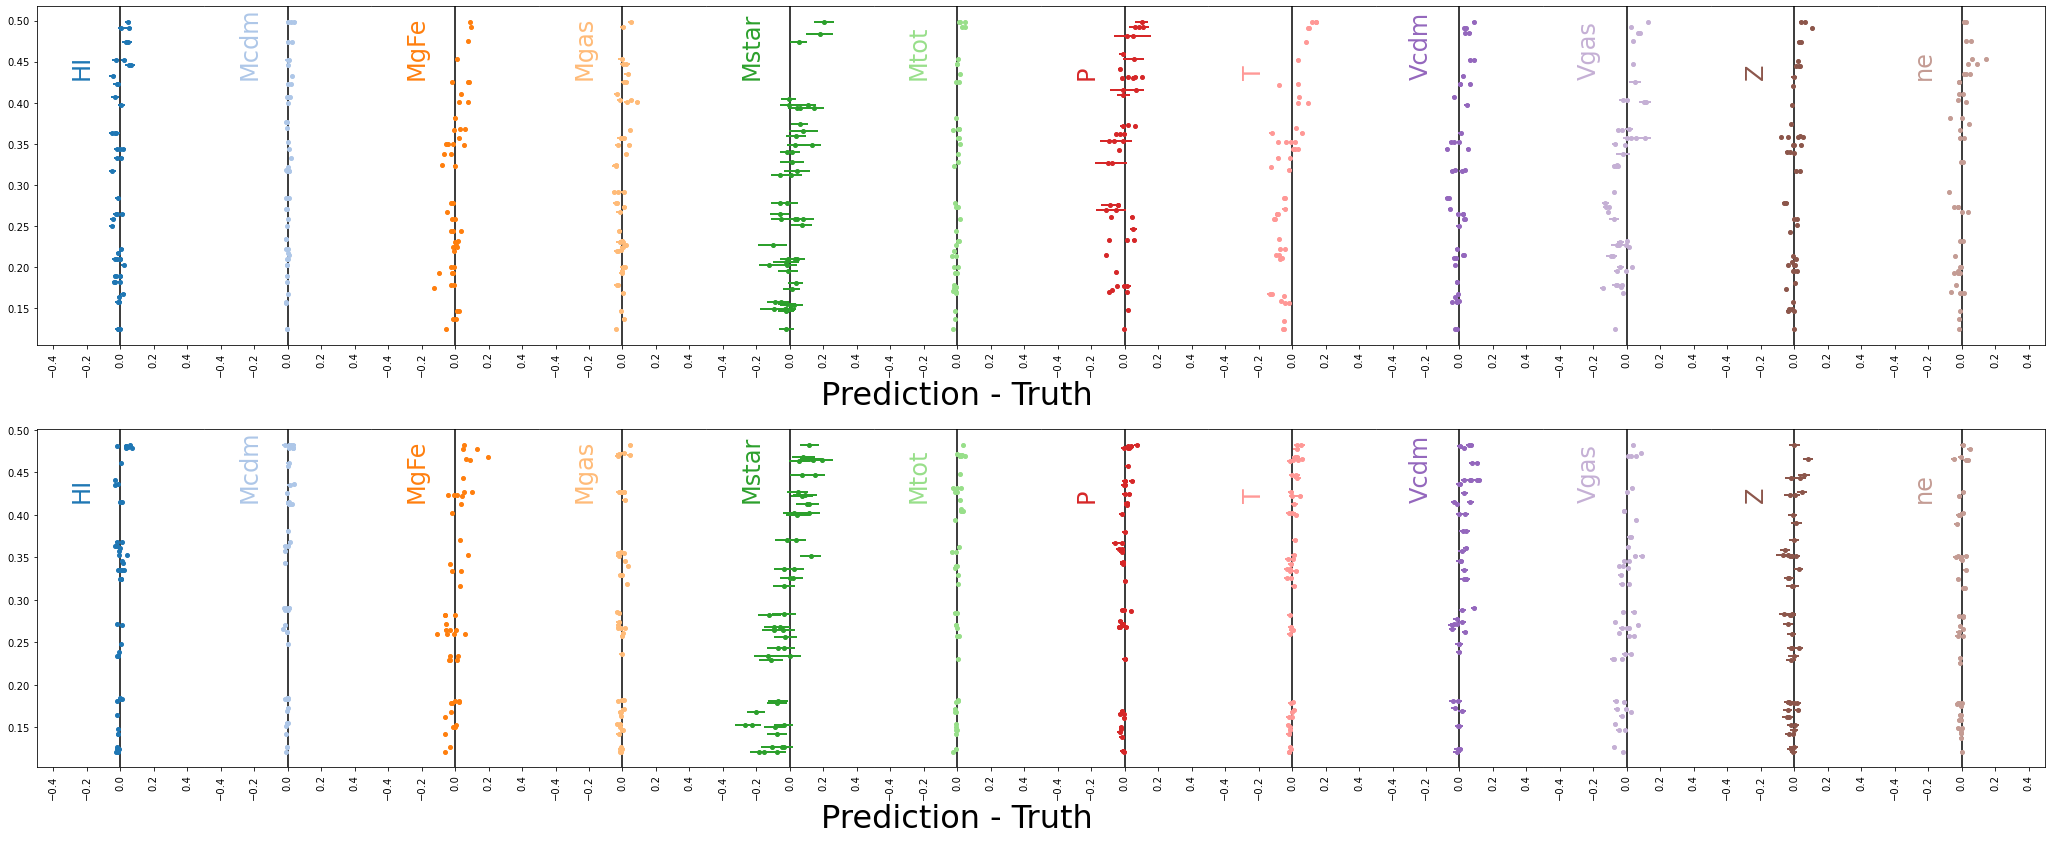

In [44]:
nr, nc = 2, 12
fig, axes = plt.subplots(nr, nc, figsize=(3*nc, 7*nr),
                         sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.25, wspace=0)

sim_types = ['SIMBA', 'IllustrisTNG']

for i, ax in enumerate(axes.flat):
  ax.axvline(x=0, color='black')
  ax.set_xlim(-0.5, 0.5)
  
  ax.tick_params(axis='x', which='major', rotation=90)
  if (0 <= i < 11) or (12 <= i < 23):
    ax.spines['right'].set_color('white')
  if (0 < i <= 11) or (12 < i <= 23):
    ax.spines['left'].set_color('white')
    ax.set_yticks([])
  if (i == 5) or (i == 17):
    ax.set_xlabel(f"$y_{{pred}} - y_{{real}}$ [{sim_types[i]}]", fontsize=32)

for i, TARGET in enumerate(sim_types):
  PREFIX, FMAPS = get_data_paths(PDIR, DDIR, TARGET=TARGET)
  for j, fdata in enumerate(FMAPS):
    ax = axes.reshape(-1)[i*12 + j]
    print(f"Current ax : {i*12 + j}")
    fparams, fmodel = get_inference_paths(DDIR, PREFIX, fdata=fdata, TARGET=TARGET)

    model = load_model(fmodel)
    fmaps = [fdata]
    fmaps_norm = [None]
    params_true, params_NN, errors_NN = \
              get_predictions(model,
                              fmaps, fmaps_norm, fparams,
                              splits, batch_size, seed)
    # select the first map of every simulation in the test set
    indexes = np.arange(params_true.shape[0]//splits)*splits
    # Plot the Omega_m predictions
    y_idx = 0
    ax.errorbar(y=params_true[indexes, y_idx],
                x=params_true[indexes, y_idx] - params_NN[indexes, y_idx],
                xerr=errors_NN[indexes, y_idx],
                linestyle='None', fmt='o', ms=4, elinewidth=2, capsize=0, c=cm.tab20(j))
    ax.text(0.2, 0.8, fmodel.split(f'{TARGET}_')[-1][:-3], rotation='vertical',
            fontsize=24, color=cm.tab20(j), transform=ax.transAxes)
  
plt.show()